In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [18]:
# Load the CSV file
file_path = "simulation_results.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Remove rows where the time column is 0, 1, or 60
filtered_df = df[~df['time'].isin([0, 1, 60])]

# # Save the filtered DataFrame to a new CSV file
# filtered_file_path = "filtered_simulation_results.csv"
# filtered_df.to_csv(filtered_file_path, index=False)

# print(f"Filtered file saved to: {filtered_file_path}")

df = filtered_df

In [19]:
# Load or prepare your dataset
simulation_data = df

# Split the dataset into features (X) and target variables (y)
X = simulation_data.drop(columns=["volAverage(T)", "volAverage(Bu)"])
y_temp = simulation_data["volAverage(T)"]

# Bin the continuous target into categories for stratification
num_bins = 10
y_temp_bins = pd.qcut(y_temp, q=num_bins, duplicates='drop', labels=False)

# Train-validation-test split: 80%-10%-10% with stratification
X_train, X_temp, y_train, y_temp, y_bins_train, y_bins_temp = train_test_split(
    X, y_temp, y_temp_bins, test_size=0.2, random_state=42, stratify=y_temp_bins
)

X_val, X_test, y_val, y_test, y_bins_val, y_bins_test = train_test_split(
    X_temp, y_temp, y_bins_temp, test_size=0.5, random_state=42, stratify=y_bins_temp
)

# Initialize scalers for features (X) and target (y)
scaler_X = StandardScaler()

# Scale the features (X)
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)



In [20]:


# Convert scaled X and y back to pandas DataFrame and Series
X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)



In [21]:
def train_and_evaluate_model_with_tuning(model_name, model_class, param_grid, X_train, y_train, X_val, y_val):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses, val_losses = [], []
    best_model = None
    best_rmse = float('inf')
    best_params = None
    evals_result = None

    # We'll use X_test, y_test from outer scope for eval_set logging.
    global X_test, y_test

    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        # Hyperparameter tuning using GridSearchCV
        base_model = model_class()
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_t, y_t)
        fold_best_params = grid_search.best_params_

        # Update model with best params and retrain
        if model_name == "LightGBM":
            model = model_class(**fold_best_params)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                eval_names=["train", "test", "valid"],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(5)]
            )
            fold_evals_result = model.evals_result_

        elif model_name == "XGBoost":
            fold_best_params["eval_metric"] = "rmse"
            model = model_class(**fold_best_params, early_stopping_rounds=5)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                verbose=False
            )
            fold_evals_result = model.evals_result()

        # Evaluate training and validation performance on the fold
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)
        train_loss = root_mean_squared_error(y_t, y_t_pred)
        val_loss = root_mean_squared_error(y_v, y_v_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Keep track of the best model across folds based on validation loss
        if val_loss < best_rmse:
            best_rmse = val_loss
            best_model = model
            best_params = fold_best_params
            evals_result = fold_evals_result

    # Final evaluation on the validation set with the best model
    y_val_pred = best_model.predict(X_val)
    final_val_rmse = root_mean_squared_error(y_val, y_val_pred)

    return {
        "model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_val_rmse": final_val_rmse,
        "best_params": best_params,
        "evals_result": evals_result
    }

# Hyperparameter grids
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}


In [6]:
lgb_results = train_and_evaluate_model_with_tuning("LightGBM", lgb.LGBMRegressor, lgb_param_grid, X_train, y_train, X_val, y_val)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 64095, number of used features: 6
[LightGBM] [Info] Start training from score 1045.605707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 64095, number of used features: 6
[LightGBM] [Info] Start training from score 1045.605707
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[200]	train's rmse: 2.33432	train's l2: 5.44907	test's rmse: 2.7055	test's l2: 7.31974	valid's rmse: 2.70742	valid's l2: 7.33012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

In [7]:
xgb_results = train_and_evaluate_model_with_tuning("XGBoost", xgb.XGBRegressor, xgb_param_grid, X_train, y_train, X_val, y_val)


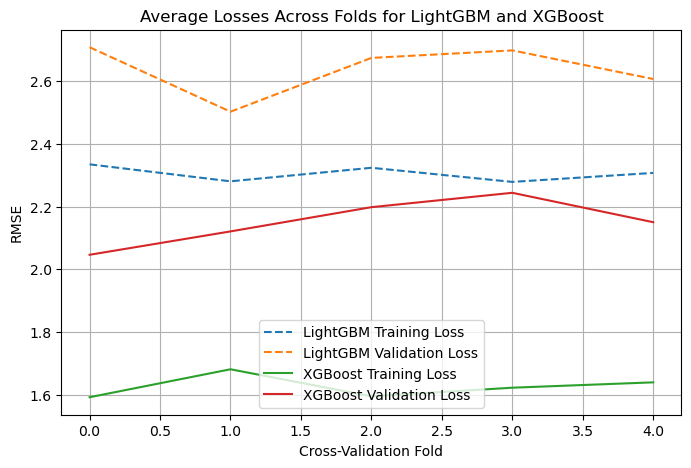

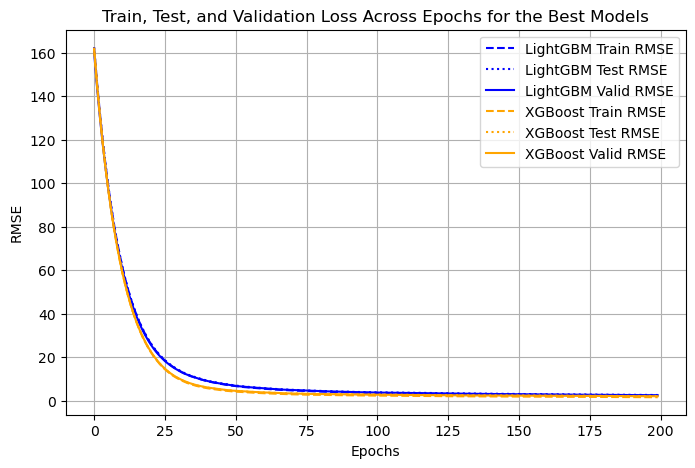

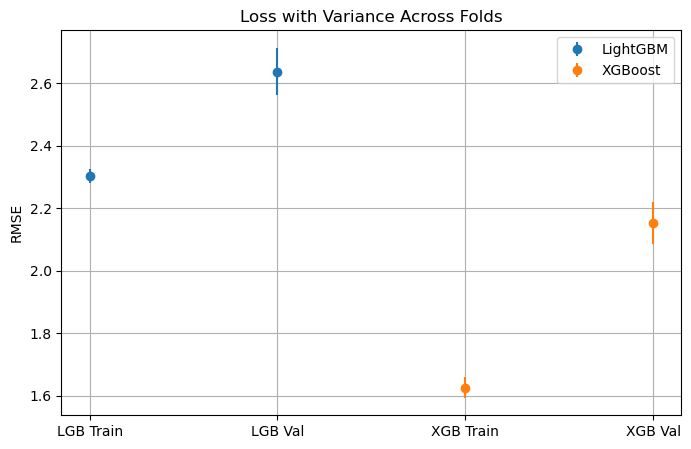

Test Results:
              RMSE       MAE        R2
LightGBM  2.613991  1.666219  0.999789
XGBoost   2.122416  1.189610  0.999861


In [8]:
# Plot Average Losses Across Folds
plt.figure(figsize=(8, 5))
plt.plot(lgb_results["train_losses"], label="LightGBM Training Loss", linestyle="--")
plt.plot(lgb_results["val_losses"], label="LightGBM Validation Loss", linestyle="--")
plt.plot(xgb_results["train_losses"], label="XGBoost Training Loss", linestyle="-")
plt.plot(xgb_results["val_losses"], label="XGBoost Validation Loss", linestyle="-")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Average Losses Across Folds for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# Plot Train, Test, and Validation Loss Across Epochs for the Best Models
plt.figure(figsize=(8, 5))

# LightGBM evals_result
if lgb_results["evals_result"] is not None:
    lgb_epochs_train = lgb_results["evals_result"]["train"]["rmse"]
    lgb_epochs_test = lgb_results["evals_result"]["test"]["rmse"]
    lgb_epochs_val = lgb_results["evals_result"]["valid"]["rmse"]
    plt.plot(lgb_epochs_train, label="LightGBM Train RMSE", linestyle='--', color='blue')
    plt.plot(lgb_epochs_test, label="LightGBM Test RMSE", linestyle=':', color='blue')
    plt.plot(lgb_epochs_val, label="LightGBM Valid RMSE", linestyle='-', color='blue')

# XGBoost evals_result
if xgb_results["evals_result"] is not None:
    xgb_epochs_train = xgb_results["evals_result"]["validation_0"]["rmse"]
    xgb_epochs_test = xgb_results["evals_result"]["validation_1"]["rmse"]
    xgb_epochs_val = xgb_results["evals_result"]["validation_2"]["rmse"]
    plt.plot(xgb_epochs_train, label="XGBoost Train RMSE", linestyle='--', color='orange')
    plt.plot(xgb_epochs_test, label="XGBoost Test RMSE", linestyle=':', color='orange')
    plt.plot(xgb_epochs_val, label="XGBoost Valid RMSE", linestyle='-', color='orange')

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Train, Test, and Validation Loss Across Epochs for the Best Models")
plt.legend()
plt.grid()
plt.show()

# Add Error Bars to Show Variance Across Folds
mean_train_loss_lgb = np.mean(lgb_results["train_losses"])
std_train_loss_lgb = np.std(lgb_results["train_losses"])
mean_val_loss_lgb = np.mean(lgb_results["val_losses"])
std_val_loss_lgb = np.std(lgb_results["val_losses"])

mean_train_loss_xgb = np.mean(xgb_results["train_losses"])
std_train_loss_xgb = np.std(xgb_results["train_losses"])
mean_val_loss_xgb = np.mean(xgb_results["val_losses"])
std_val_loss_xgb = np.std(xgb_results["val_losses"])

plt.figure(figsize=(8, 5))
plt.errorbar(["LGB Train", "LGB Val"], [mean_train_loss_lgb, mean_val_loss_lgb], 
             yerr=[std_train_loss_lgb, std_val_loss_lgb], fmt="o", label="LightGBM")
plt.errorbar(["XGB Train", "XGB Val"], [mean_train_loss_xgb, mean_val_loss_xgb], 
             yerr=[std_train_loss_xgb, std_val_loss_xgb], fmt="o", label="XGBoost")
plt.ylabel("RMSE")
plt.title("Loss with Variance Across Folds")
plt.legend()
plt.grid()
plt.show()

# Final Test Evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": root_mean_squared_error(y_test, lgb_test_pred),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": root_mean_squared_error(y_test, xgb_test_pred),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("Test Results:")
print(test_results_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 80119, number of used features: 6
[LightGBM] [Info] Start training from score 1045.736724


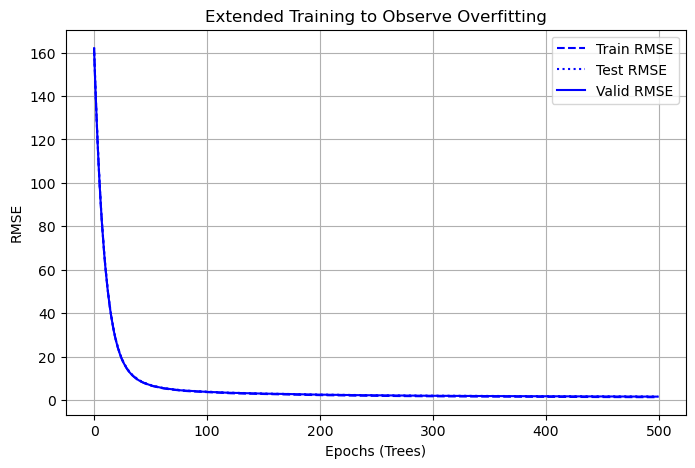

In [9]:
# Suppose after tuning, you have:
best_params = lgb_results["best_params"]  # For LightGBM as an example

# Let's say we want to train for 500 trees to observe overfitting behavior
long_run_params = best_params.copy()
long_run_params["n_estimators"] = 500  # Increase number of trees
# Remove or do not use early_stopping callback

model = lgb.LGBMRegressor(**long_run_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test), (X_val, y_val)],
    eval_names=["train", "test", "valid"],
    eval_metric="rmse",
    # No early stopping callback here
)

# Retrieve results
evals_result_long = model.evals_result_

# Plot the curves
plt.figure(figsize=(8, 5))
plt.plot(evals_result_long["train"]["rmse"], label="Train RMSE", linestyle='--', color='blue')
plt.plot(evals_result_long["test"]["rmse"], label="Test RMSE", linestyle=':', color='blue')
plt.plot(evals_result_long["valid"]["rmse"], label="Valid RMSE", linestyle='-', color='blue')
plt.xlabel("Epochs (Trees)")
plt.ylabel("RMSE")
plt.title("Extended Training to Observe Overfitting")
plt.legend()
plt.grid()
plt.show()


RMSE for LightGBM (Unscaled): 2.6140
RMSE for XGBoost (Unscaled): 2.1224
Real Temperature Predictions (Unscaled):
      Actual  LGBM Prediction  XGBoost Prediction
0  1136.8060      1136.843906         1136.697754
1  1131.2230      1132.387233         1130.673096
2   922.3612       922.641198          920.909851
3  1208.7180      1206.389746         1211.718262
4   791.9746       791.482174          790.814758


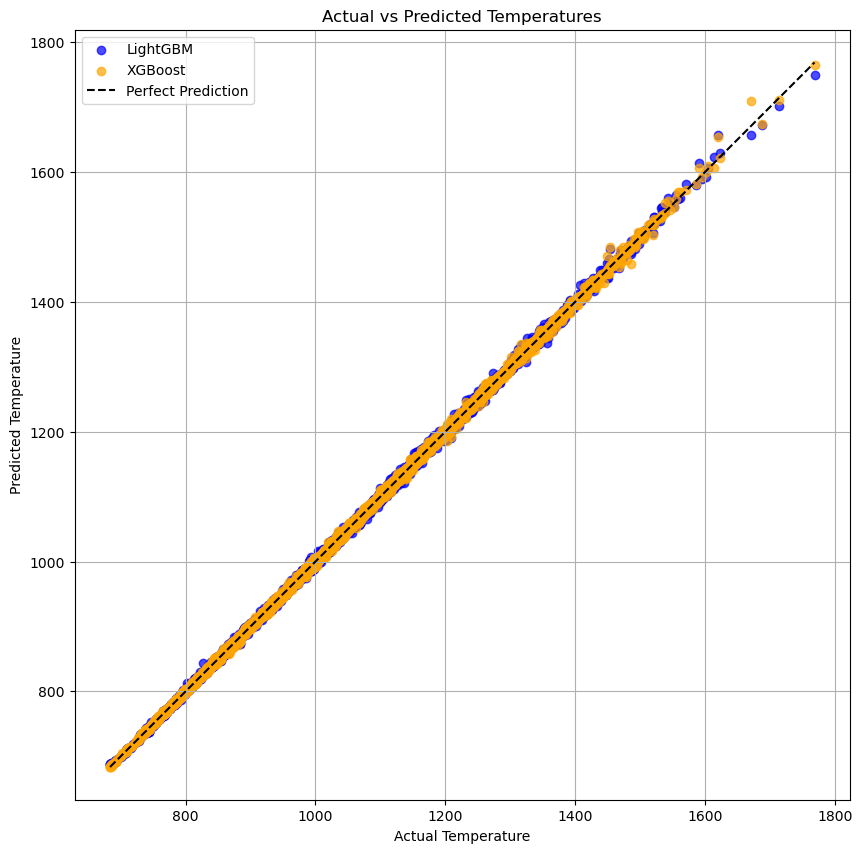

In [13]:
# Combine actual and predicted values into a DataFrame for easier visualization
results_df = pd.DataFrame({
    "Actual": y_test.to_numpy(),  # Actual values (unscaled)
    "LGBM Prediction": lgb_test_pred,  # LightGBM predictions
    "XGBoost Prediction": xgb_test_pred  # XGBoost predictions
})

# Calculate RMSE for LightGBM and XGBoost predictions
rmse_lgb_real = root_mean_squared_error(y_test.to_numpy(), lgb_test_pred)
rmse_xgb_real = root_mean_squared_error(y_test.to_numpy(), xgb_test_pred)

# Print the RMSE results
print(f"RMSE for LightGBM (Unscaled): {rmse_lgb_real:.4f}")
print(f"RMSE for XGBoost (Unscaled): {rmse_xgb_real:.4f}")

# Print the results DataFrame for verification
print("Real Temperature Predictions (Unscaled):")
print(results_df.head())

# Plot to compare actual and predicted values
plt.figure(figsize=(10, 10))

# Scatter plot for actual vs LightGBM predictions
plt.scatter(y_test, lgb_test_pred, label="LightGBM", alpha=0.7, color="blue")
# Scatter plot for actual vs XGBoost predictions
plt.scatter(y_test, xgb_test_pred, label="XGBoost", alpha=0.7, color="orange")

# Add a reference line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         label="Perfect Prediction", linestyle="--", color="black")

# Set axis limits and make axes equal
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.axis("equal")  # Ensures equal scaling

plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted Temperatures")
plt.legend()
plt.grid()
plt.show()




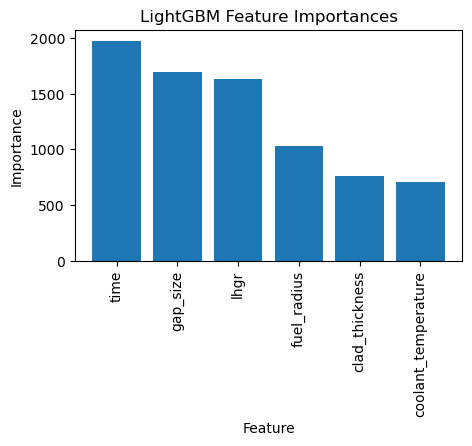

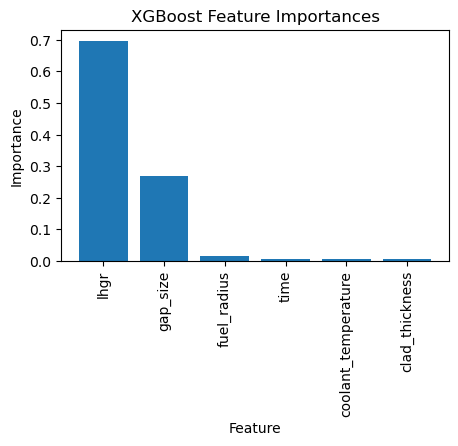

In [16]:
def plot_feature_importance(model, feature_names, model_name):
    """
    Plot feature importance for a given model.
    """
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(5, 3))
        plt.bar(range(len(importances)), importances[sorted_indices], align="center")
        plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_indices], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title(f"{model_name} Feature Importances")
        plt.show()
    else:
        print(f"The model '{model_name}' does not have feature_importances_ attribute.")

# Example: Plot feature importances for the best LightGBM model
plot_feature_importance(lgb_results["model"], X_train.columns, "LightGBM")
plot_feature_importance(xgb_results["model"], X_train.columns, "XGBoost")

In [23]:
def dilute_time_samples(data, time_col, dilution_factor):
    """
    Dilutes the dataset by randomly removing a fraction of time samples for each unique feature combination.

    Parameters:
        data (pd.DataFrame): Input dataset.
        time_col (str): The column name representing time.
        dilution_factor (float): Fraction of time samples to remove (0 <= dilution_factor < 1).

    Returns:
        pd.DataFrame: Diluted dataset.
    """
    diluted_data = []

    # Group by feature combinations excluding the time column
    feature_groups = data.groupby(data.columns.difference([time_col]).tolist())

    for _, group in feature_groups:
        n_samples = len(group)
        n_to_keep = max(1, int((1 - dilution_factor) * n_samples))
        diluted_group = group.sample(n=n_to_keep, random_state=42)
        diluted_data.append(diluted_group)

    return pd.concat(diluted_data, ignore_index=True)

def evaluate_dilution_impact(dilution_factors, model_name, model_class, param_grid, X_train, X_val, X_test, y_train, y_val, y_test, time_col):
    """
    Evaluate the impact of dilution on model performance.

    Parameters:
        dilution_factors (list): List of dilution factors to evaluate.
        model_name (str): Name of the model (e.g., 'LightGBM').
        model_class: Model class (e.g., lgb.LGBMRegressor).
        param_grid (dict): Hyperparameter grid for tuning.
        X_train, X_val, X_test (pd.DataFrame): Features.
        y_train, y_val, y_test (pd.Series): Target variables.
        time_col (str): The column name representing time.

    Returns:
        dict: RMSE values for each dilution factor.
    """
    results = {}

    for factor in dilution_factors:
        # Combine train, validation, and test data for dilution
        combined_X = pd.concat([X_train, X_val, X_test], axis=0)
        combined_y = pd.concat([y_train, y_val, y_test], axis=0)
        combined_data = pd.concat([combined_X, combined_y], axis=1)

        # Dilute dataset
        diluted_data = dilute_time_samples(combined_data, time_col, factor)
        X_diluted = diluted_data[X_train.columns]
        y_diluted = diluted_data[combined_y.name]

        # Split back into train, validation, and test sets
        X_train_diluted, X_temp, y_train_diluted, y_temp = train_test_split(
            X_diluted, y_diluted, test_size=0.4, random_state=42
        )
        X_val_diluted, X_test_diluted, y_val_diluted, y_test_diluted = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42
        )

        # Train and evaluate model
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        best_rmse = float("inf")

        for train_index, val_index in kf.split(X_train_diluted):
            X_t, X_v = X_train_diluted.iloc[train_index], X_train_diluted.iloc[val_index]
            y_t, y_v = y_train_diluted.iloc[train_index], y_train_diluted.iloc[val_index]

            grid_search = GridSearchCV(
                estimator=model_class(),
                param_grid=param_grid,
                scoring='neg_root_mean_squared_error',
                cv=3,
                verbose=0,
                n_jobs=-1
            )
            grid_search.fit(X_t, y_t)
            best_params = grid_search.best_params_

            model = model_class(**best_params)
            model.fit(X_t, y_t)
            y_v_pred = model.predict(X_v)
            rmse = root_mean_squared_error(y_v, y_v_pred)

            best_rmse = min(best_rmse, rmse)

        results[factor] = best_rmse

    return results

# Specify dilution factors to test
dilution_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # 0.0 means no dilution

time_col = 'time'

# Evaluate LightGBM model
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
lgb_results = evaluate_dilution_impact(
    dilution_factors, "LightGBM", lgb.LGBMRegressor, lgb_param_grid,
    X_train, X_val, X_test, y_train, y_val, y_test, time_col
)

# Evaluate XGBoost model
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_results = evaluate_dilution_impact(
    dilution_factors, "XGBoost", xgb.XGBRegressor, xgb_param_grid,
    X_train, X_val, X_test, y_train, y_val, y_test, time_col
)

# Plot RMSE vs Dilution Factor
plt.figure(figsize=(8, 6))
plt.plot(dilution_factors, list(lgb_results.values()), label="LightGBM", marker='o')
plt.plot(dilution_factors, list(xgb_results.values()), label="XGBoost", marker='o')
plt.xlabel("Dilution Factor")
plt.ylabel("RMSE")
plt.title("RMSE vs Dilution Factor")
plt.legend()
plt.grid()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 12819, number of used features: 6
[LightGBM] [Info] Start training from score 1047.114301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 12819, number of used features: 6
[LightGBM] [Info] Start training from score 1047.114301


TypeError: got an unexpected keyword argument 'squared'